In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk

/Users/JoeMcLaughlin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('frmgham2.csv')

In [4]:
df.head()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766


In the previoius analysis of this data, we looked at some of the trends seen in the data and how some of the features relate to Death and cardiovascular events. 

In this notebook, we will be cleaning and normalisng the data in order to best prepare the data for a random forest model. 

In [5]:
df.columns

Index(['RANDID', 'SEX', 'TOTCHOL', 'AGE', 'SYSBP', 'DIABP', 'CURSMOKE',
       'CIGPDAY', 'BMI', 'DIABETES', 'BPMEDS', 'HEARTRTE', 'GLUCOSE', 'educ',
       'PREVCHD', 'PREVAP', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'TIME', 'PERIOD',
       'HDLC', 'LDLC', 'DEATH', 'ANGINA', 'HOSPMI', 'MI_FCHD', 'ANYCHD',
       'STROKE', 'CVD', 'HYPERTEN', 'TIMEAP', 'TIMEMI', 'TIMEMIFC', 'TIMECHD',
       'TIMESTRK', 'TIMECVD', 'TIMEDTH', 'TIMEHYP'],
      dtype='object')

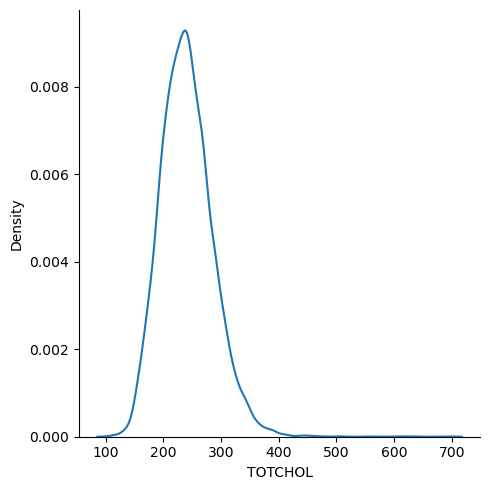

In [6]:
sns.displot(data=df, x ="TOTCHOL", kind = "kde")

<AxesSubplot: xlabel='TOTCHOL'>

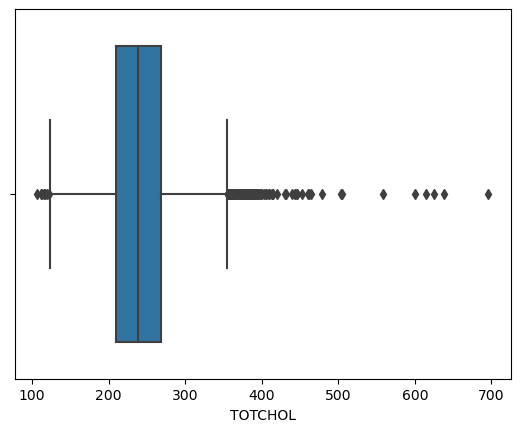

In [7]:
sns.boxplot(data=df, x = "TOTCHOL")

In [8]:
df.TOTCHOL.describe()

count    11218.000000
mean       241.162418
std         45.368030
min        107.000000
25%        210.000000
50%        238.000000
75%        268.000000
max        696.000000
Name: TOTCHOL, dtype: float64

In [9]:
def percent_missing(df):
    total_values = len(df)
    missing_count = df.isnull().sum()
    percent_missing = (missing_count/total_values) * 100
    percent_missing.sort_values(ascending=False, inplace=True)
    return percent_missing[percent_missing > 0]

percent_missing_df = percent_missing(df)
percent_missing_df

LDLC        73.974370
HDLC        73.965769
GLUCOSE     12.384966
BPMEDS       5.100198
TOTCHOL      3.517674
educ         2.537198
CIGPDAY      0.679453
BMI          0.447235
HEARTRTE     0.051604
dtype: float64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'LDLC'),
  Text(1, 0, 'HDLC'),
  Text(2, 0, 'GLUCOSE'),
  Text(3, 0, 'BPMEDS'),
  Text(4, 0, 'TOTCHOL'),
  Text(5, 0, 'educ'),
  Text(6, 0, 'CIGPDAY'),
  Text(7, 0, 'BMI'),
  Text(8, 0, 'HEARTRTE')])

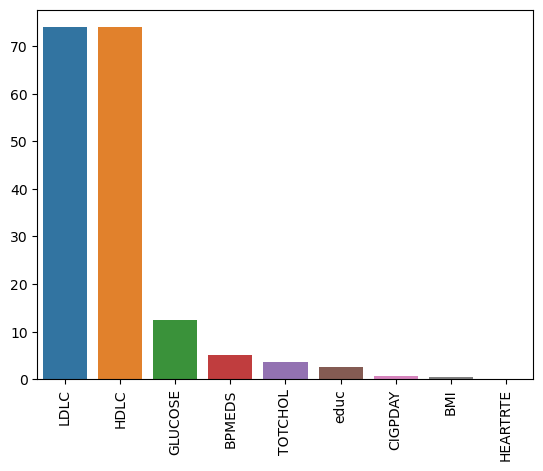

In [10]:
sns.barplot(x = percent_missing_df.index, y = percent_missing_df)
plt.xticks(rotation=90)

From this plot we can see that LDLC and HDLC are missing > 70% of their data. We will therefore remove these columns from the dataset. 
Whilst glucose, BMI and SBP are missing < 30% of their data, we will keep these columns in the dataset as they are likely omitted because this data does not aplly to the patient (e.g. a patient with no diabetes will not have a glucose reading).

I am interested to see how many participants have missing values for each of the features with missing data.

In [11]:
percent_missing_df.index
for x in percent_missing_df.index:
    print(x + ": " + str(len(df[df[x].isnull()].groupby('RANDID'))))

LDLC: 4434
HDLC: 4434
GLUCOSE: 1253
BPMEDS: 580
TOTCHOL: 368
educ: 113
CIGPDAY: 78
BMI: 44
HEARTRTE: 6


For the missing data we could ideally inspect the data to see if the data was missing for all of the participant's visits, and then perhaps use an average of their other visits, such as using an average of their heart rates if they were fairly similar. However for the sake of time, I will only do this for the Heart Rate feature.

In [12]:
df[df['HEARTRTE'].isnull()].RANDID

1299     1080920
1434     1186959
1847     1557925
2630     2235925
3500     3029122
10250    8878837
Name: RANDID, dtype: int64

In [13]:
df[df['RANDID'] == 1080920].HEARTRTE

1298    92.0
1299     NaN
Name: HEARTRTE, dtype: float64

In [14]:
for x in df[df['HEARTRTE'].isnull()].RANDID:
    print(str(x) + ": " + str(df[df['RANDID'] == x].HEARTRTE.values))

1080920: [92. nan]
1186959: [85. nan]
1557925: [nan 80.]
2235925: [86. 80. nan]
3029122: [80. nan]
8878837: [75. 70. nan]


Looking at these values I think that the right thing to do here is to use the average of the other visits for the missing values. If there is only one visit, then we will just use the value for that visit.

In [15]:
for x in df[df['HEARTRTE'].isnull()].RANDID:
    df[df["RANDID" == x].isnull()] = df[df[df['RANDID'] == x].notnull()].HEARTRTE.mean()

KeyError: False

In [ ]:
for x in df[df['HEARTRTE'].isnull()].RANDID:
    print(str(x) + ": " + str(df[df['RANDID'] == x].HEARTRTE.values))

1080920: [92. nan]
1186959: [85. nan]
1557925: [nan 80.]
2235925: [86. 80. nan]
3029122: [80. nan]
8878837: [75. 70. nan]


In [ ]:
df[df[df['RANDID'] == 1080920].notnull()].HEARTRTE.mean()

92.0

In [ ]:
df[df[df['RANDID'] == 1080920] & df.notnull()]

NameError: name 'df' is not defined

In [ ]:
df.head()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP,False
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,0.666667
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,0,8766,6438,6438,6438,8766,6438,8766,8766,0.666667
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,0.666667
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,0.666667
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,8766,8766,8766,8766,8766,8766,8766,8766,0.666667
